## Problem statement: 
- “Predict Possibility of Patient Readmission within 60days from discharge”

## To do:
1.	Exploratory Data Analysis
2.	Assumptions (if any)
3.	Feature Engineering & Feature Selection
4.	Model Building
5.	Predicted output
6.	Model Evaluation Metrics

- - - -

## Code:

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

### Read Data

In [2]:
admissions = pd.read_csv('readmission_data//ADMISSIONS.csv')
services = pd.read_csv('readmission_data//SERVICES.csv')
icd = pd.read_csv('readmission_data//DIAGNOSES_ICD.csv')
d_icd = pd.read_csv('readmission_data//D_ICD_DIAGNOSES.csv')
icu_stays = pd.read_csv("readmission_data//ICUSTAYS.csv")
patients = pd.read_csv('readmission_data//PATIENTS.csv')
drg_codes = pd.read_csv('readmission_data//DRGCODES.csv')

### Prepare a KEY

In [3]:
admissions['SUBJECT_ID'] = admissions['SUBJECT_ID'].astype(str)
admissions['HADM_ID'] = admissions['HADM_ID'].astype(str)
admissions['key'] = admissions[['SUBJECT_ID', 'HADM_ID']].apply(lambda x: ''.join(x), axis=1)

services['SUBJECT_ID'] = services['SUBJECT_ID'].astype(str)
services['HADM_ID'] = services['HADM_ID'].astype(str)
services['key'] = services[['SUBJECT_ID', 'HADM_ID']].apply(lambda x: ''.join(x), axis=1)

icd['SUBJECT_ID'] = icd['SUBJECT_ID'].astype(str)
icd['HADM_ID'] = icd['HADM_ID'].astype(str)
icd['key'] = icd[['SUBJECT_ID', 'HADM_ID']].apply(lambda x: ''.join(x), axis=1)

icu_stays['SUBJECT_ID'] = icu_stays['SUBJECT_ID'].astype(str)
icu_stays['HADM_ID'] = icu_stays['HADM_ID'].astype(str)
icu_stays['key'] = icu_stays[['SUBJECT_ID', 'HADM_ID']].apply(lambda x: ''.join(x), axis=1)

drg_codes['SUBJECT_ID'] = drg_codes['SUBJECT_ID'].astype(str)
drg_codes['HADM_ID'] = drg_codes['HADM_ID'].astype(str)
drg_codes['key'] = drg_codes[['SUBJECT_ID', 'HADM_ID']].apply(lambda x: ''.join(x), axis=1)

### Drop un-wanted columns
- **Column: Reason**
- ROW_ID: Unique
- HADM_ID: Already formed a key
- DESCRIPTION: Text
- DRG_SEVERITY: 46% Missing
- DRG_MORTALITY: 46% Missing
- DOB: Invalid dates, Cant use to get age
- DOD: Already we have expire flag
- DOD_HOSP: 79% Blanks
- DOD_SSN: 72% Blanks
- ICUSTAY_ID: Unique
- INTIME: Already we have LOS
- OUTTIME: Already we have LOS
- SHORT_TITLE: text
- LONG_TITLE: text
- SEQ_NUM: Key
- TRANSFERTIME: Not found useful
- EDREGTIME: Not found useful
- EDOUTTIME: Not found useful
- DIAGNOSIS: Not found useful

In [4]:
admission_drop = ["ROW_ID", "HADM_ID", "EDREGTIME", "EDOUTTIME", "DIAGNOSIS"]
services_drop = ["ROW_ID", "HADM_ID", "TRANSFERTIME", "SUBJECT_ID"]
icd_drop = ["ROW_ID", "HADM_ID", "SEQ_NUM", "SUBJECT_ID"]
d_icd_drop = ["ROW_ID", "SHORT_TITLE", "LONG_TITLE"]
icu_stays_drop = ["ROW_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "SUBJECT_ID"]
patients_drop = ["ROW_ID", "DOB", "DOD", "DOD_HOSP", "DOD_SSN"]
drg_codes_drop = ["ROW_ID", "HADM_ID", "DESCRIPTION", "DRG_SEVERITY", "DRG_MORTALITY", "SUBJECT_ID"]

In [5]:
admissions.drop(admission_drop, axis=1, inplace=True)
services.drop(services_drop, axis=1, inplace=True)
icd.drop(icd_drop, axis=1, inplace=True)
d_icd.drop(d_icd_drop, axis=1, inplace=True)
icu_stays.drop(icu_stays_drop, axis=1, inplace=True)
patients.drop(patients_drop, axis=1, inplace=True)
drg_codes.drop(drg_codes_drop, axis=1, inplace=True)

### Drop duplicates

In [6]:
admissions = admissions.drop_duplicates()
services = services.drop_duplicates()
icd = icd.drop_duplicates()
d_icd = d_icd.drop_duplicates()
icu_stays = icu_stays.drop_duplicates()
patients = patients.drop_duplicates()
drg_codes = drg_codes.drop_duplicates()

In [7]:
# # delete unwanted objects
del admission_drop
del services_drop
del icd_drop
del d_icd_drop
del icu_stays_drop
del patients_drop
del drg_codes_drop

### Clean tables for preparing Master table

In [8]:
services = services[['key', 'CURR_SERVICE']].groupby('key').agg('count').reset_index()
services.columns = ['key', 'service_ct']
icd = icd[['key', 'ICD9_CODE']].groupby('key').agg('count').reset_index()
icd.columns = ['key', 'icd_ct']

In [9]:
drg_codes['APR'] = [1 if i == 'APR ' else 0 for i in drg_codes.DRG_TYPE]
drg_codes['HCFA'] = [1 if i == 'HCFA' else 0 for i in drg_codes.DRG_TYPE]
drg_codes['MS'] = [1 if i == 'MS ' else 0 for i in drg_codes.DRG_TYPE]
drg_codes.drop(['DRG_TYPE', 'DRG_CODE'], axis = 1, inplace=True)
drg_codes = drg_codes.groupby('key').agg('sum').reset_index()
drg_codes = drg_codes.drop_duplicates()

In [10]:
icu_stays1 = icu_stays[['key', 'LOS']].groupby('key').agg('mean').reset_index()
icu_stays2 = icu_stays[['key', 'LOS']].groupby('key').agg('count').reset_index()
icu_stays3 = icu_stays1.merge(icu_stays2, left_on='key', right_on='key', how='inner')
icu_stays3.columns = ['key', 'Avg_LOS', 'N_CAREUNITS']
icu_stays3 = icu_stays3.merge(icu_stays[['key', 'DBSOURCE']], left_on = 'key', right_on='key', how = 'left')
icu_stays3 = icu_stays3.drop_duplicates()
del icu_stays1
del icu_stays2
icu_stays = icu_stays3
del icu_stays3

### Prepare Master

In [11]:
# # prepare master
admissions['SUBJECT_ID'] = admissions['SUBJECT_ID'].astype('int')
admissions = admissions.merge(patients, on = 'SUBJECT_ID', how = 'left')
admissions = admissions.merge(services, on = 'key', how = 'left')
admissions = admissions.merge(icd, on = 'key', how = 'left')
admissions = admissions.merge(icu_stays, on = 'key', how = 'left')
admissions = admissions.merge(drg_codes, on = 'key', how = 'left')

### Prepare Target

In [12]:
admissions['ADMITTIME'] = pd.to_datetime(admissions.ADMITTIME)
admissions['DISCHTIME'] = pd.to_datetime(admissions.DISCHTIME)
admissions['DEATHTIME'] = pd.to_datetime(admissions.DEATHTIME)

In [13]:
admissions['SUBJECT_ID'] = admissions['SUBJECT_ID'].astype('int')

In [14]:
admissions = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'], ascending=[True, True])

In [15]:
admissions['target'] = 0
admissions = admissions.reset_index()
del admissions['index']

In [16]:
n = admissions.shape[0]

In [17]:
def prepare_target(admissions, n):
    i = 0
    while i < n:
        temp = admissions.SUBJECT_ID[i]
        count = admissions[admissions.SUBJECT_ID == temp].shape[0]
        if count == 1:
            i = i + 1
        else:
            while count > 1:
                tempadmitdate = admissions.ADMITTIME[i + 1]
                tempdichargedate = admissions.DISCHTIME[i]
                if (tempdichargedate - tempadmitdate).days < 60:
                    admissions['target'][i] = 1
                i = i + 1
                count = count - 1
            i = i + 1
    return(admissions)

In [18]:
temp_admissions = admissions.copy() # take a backup !
admissions = prepare_target(admissions = admissions, n = n)

In [19]:
# admissions = pd.read_csv('..//data//full_data.csv')

In [20]:
# del admissions['daystoadmit']

In [21]:
## check target class
admissions['target'].value_counts(normalize=True) # only 6.2% of 1's

0    0.788795
1    0.211205
Name: target, dtype: float64

### Check and handle missing values

In [22]:
admissions.isnull().sum(axis=0)

SUBJECT_ID                  0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
key                         0
GENDER                      0
EXPIRE_FLAG                 0
service_ct                 50
icd_ct                      0
Avg_LOS                  1200
N_CAREUNITS              1190
DBSOURCE                 1190
APR                        86
HCFA                       86
MS                         86
target                      0
dtype: int64

In [23]:
drop_cols = ['DEATHTIME', 'LANGUAGE', 'MARITAL_STATUS'] # many missing !
admissions.drop(drop_cols, axis = 1, inplace = True)

In [24]:
admissions['Avg_LOS'].fillna((admissions['Avg_LOS'].mean()), inplace=True)
admissions['N_CAREUNITS'].fillna((admissions['N_CAREUNITS'].mean()), inplace=True)
admissions['HCFA'].fillna((admissions['HCFA'].mode()[0]), inplace=True)
admissions['APR'].fillna((admissions['APR'].mode()[0]), inplace=True)
admissions['MS'].fillna((admissions['MS'].mode()[0]), inplace=True)
admissions['service_ct'].fillna((admissions['service_ct'].mean()), inplace=True)

In [25]:
admissions['DBSOURCE'].fillna('carevue', inplace = True)
admissions['RELIGION'].fillna('CATHOLIC', inplace = True)

### EDA

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def group_bar(data, column, n_groups, x_label, title, labels):
    no = np.array(data[[column, 'target']][data.target == 0].groupby(column).agg('count').reset_index()['target'])
    yes = np.array(data[[column, 'target']][data.target == 1].groupby(column).agg('count').reset_index()['target'])
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    rects1 = plt.bar(index, no, bar_width, alpha=0.4, color='y', label='NO')
    rects2 = plt.bar(index + bar_width, yes, bar_width, alpha=0.4, color='r', label='YES')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()
    plt.tight_layout()
    return plt

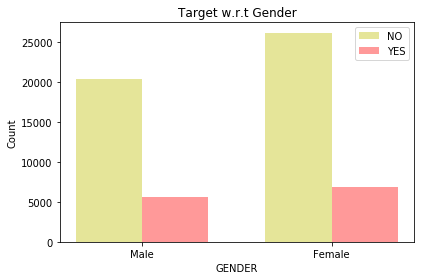

In [28]:
p1 = group_bar(admissions, 'GENDER', 2, 'GENDER', 'Target w.r.t Gender', ['Male', 'Female'])

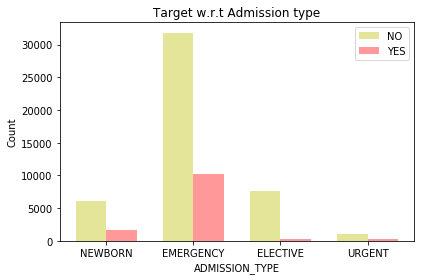

In [29]:
p2 = group_bar(admissions, 'ADMISSION_TYPE', 4, 'ADMISSION_TYPE', 'Target w.r.t Admission type', ["NEWBORN", "EMERGENCY", "ELECTIVE", "URGENT"])

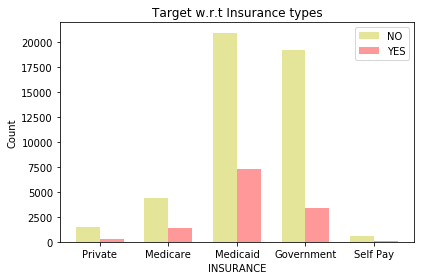

In [30]:
types = ["Private", "Medicare", "Medicaid", "Government", "Self Pay"]
p3 = group_bar(admissions, 'INSURANCE', 5, 'INSURANCE', 'Target w.r.t Insurance types', types)

### Prepare Model data

In [31]:
from sklearn.preprocessing import LabelEncoder

In [32]:
# not required for model
drop_cols = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "ADMISSION_LOCATION", "DISCHARGE_LOCATION", "key"]
# categorical columns
cat_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'DBSOURCE', 'GENDER']

In [33]:
t_admissions = admissions.copy()

In [34]:
le = LabelEncoder()
for eachCol in cat_cols:
    admissions[eachCol] = le.fit_transform(admissions[eachCol])

In [35]:
admissions.drop(drop_cols, axis = 1, inplace = True)

### Build Model

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
# conda install -c conda-forge imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [37]:
def data_sampling(X, y, method = 'rus', kind = 'regular', seed = 0):
    """
    Function to balance classes using random under sampling or smote
    Parameters:
        X: the independent variable values in a numpy array / pandas dataframe
        y: the target variable valeus in a numpy array / pandas dataframe
        method: currently accepts: 'rus' or 'smote'
        kind: parameter for smote where kind = ['regular', 'borderline1', 'borderline2', 'svm']
        seed: A random seed to maintain reproducability
    """
    if method == 'smote':
        sm = SMOTE(kind = kind)
        X_res, y_res = sm.fit_sample(X, y)
    else:
        rus = RandomUnderSampler(return_indices = True, random_state = seed)
        X_res, y_res, idx_res = rus.fit_sample(X, y)
    return {'X' : X_res, 'y' : y_res}

In [38]:
feature_names = [x for x in admissions.columns if x not in ['target']]
target = admissions['target']

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(admissions[feature_names], target, train_size = 0.7, stratify = target, random_state = 0)

#### Handling Imbalance with RUS & SMOTE

In [40]:
smote = data_sampling(X_train, y_train, method = 'rus')
X_SMOTE_train = smote['X']
y_SMOTE_train = smote['y']

In [41]:
pd.DataFrame({'target' : y_SMOTE_train})['target'].value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

#### 1) Random Forest

In [42]:
clf = RandomForestClassifier(random_state=0)

In [43]:
cross_val_score(clf, X_SMOTE_train, y_SMOTE_train, cv=5)

array([0.68922018, 0.68176606, 0.67029817, 0.67230505, 0.68559954])

In [44]:
clf.fit(X_SMOTE_train, y_SMOTE_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [45]:
f1_score(y_valid, clf.predict(X_valid))

0.476584836833284

In [ ]:
from xgboost import XGBClassifier